**Step 3 Feature Engineering**

In [3]:
import sys
print(sys.executable)

c:\Users\HomePC\Crypto-BuySell-Classifier-Model\myenv\Scripts\python.exe


In [10]:
import pandas as pd
import ta
from pathlib import Path
import matplotlib.pyplot as plt

In [5]:
df=pd.read_csv(r"C:\Users\HomePC\Crypto-BuySell-Classifier-Model\notebooks\data\processed\BTCUSDT_1d.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   open_time           1000 non-null   int64  
 1   open                1000 non-null   float64
 2   high                1000 non-null   float64
 3   low                 1000 non-null   float64
 4   close               1000 non-null   float64
 5   volume              1000 non-null   float64
 6   close_time          1000 non-null   int64  
 7   quote_asset_volume  1000 non-null   float64
 8   num_trades          1000 non-null   float64
 9   taker_base_volume   1000 non-null   float64
 10  taker_quote_volume  1000 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 86.1 KB


In [6]:
def add_basic_features(df):

    # Returns
    df['return_1d'] = df['close'].pct_change(1)
    df['return_7d'] = df['close'].pct_change(7)
    
    # Rolling volatility
    df['volatility_7d'] = df['return_1d'].rolling(window=7).std()
    
    # RSI
    df["rsi"] = ta.momentum.RSIIndicator(close=df["close"], window=14).rsi()
    
    # MACD
    df['macd'] = ta.trend.MACD(df['close']).macd_diff()
    
    # Moving averages
    df["sma_20"] = df["close"].rolling(20).mean()
    df["sma_50"] = df["close"].rolling(50).mean()
    df["sma_200"] = df["close"].rolling(200).mean()
    
    # Bollinger Bands
    bb = ta.volatility.BollingerBands(close=df["close"], window=20, window_dev=2)
    df["bb_high"] = bb.bollinger_hband()
    df["bb_low"] = bb.bollinger_lband()
    df["bb_pct"] = bb.bollinger_pband()
    
    # Stochastic RSI
    stoch = ta.momentum.StochRSIIndicator(close=df["close"], window=14, smooth1=3, smooth2=3)
    df["stoch_rsi"] = stoch.stochrsi()
    df["stoch_rsi_d"] = stoch.stochrsi_d()
    df["stoch_rsi_k"] = stoch.stochrsi_k()
    
    # Drop NaNs caused by rolling windows
    df = df.dropna().reset_index(drop=True)
    return df

In [7]:
def process_and_save(raw_csv_path, out_dir="data/processed"):
    """Load raw CSV, add features, and save processed CSV."""
    raw_csv_path = Path(raw_csv_path)
    df = pd.read_csv(raw_csv_path)
    
    # Compute all features
    df_features = add_basic_features(df)
    
    # Ensure output directory exists
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    
    # Save processed features
    out_path = Path(out_dir) / raw_csv_path.name.replace(".csv", "_features.csv")
    df_features.to_csv(out_path, index=False)
    print(f"Saved features to: {out_path}")
    
    return df_features

In [8]:
if __name__ == "__main__":
    raw_file = r"C:\Users\HomePC\Crypto-BuySell-Classifier-Model\notebooks\data\raw\BTCUSDT_1d.csv"
    df = process_and_save(raw_file)
    
    print("Processed DataFrame shape:", df.shape)
    print(df.head())

Saved features to: data\processed\BTCUSDT_1d_features.csv
Processed DataFrame shape: (801, 26)
       open_time      open      high       low     close       volume  \
0  1695168000000  27210.25  27388.63  26800.00  27125.00  34207.21867   
1  1695254400000  27125.01  27159.60  26377.70  26568.08  34476.82662   
2  1695340800000  26568.08  26743.38  26468.77  26580.14  18198.22920   
3  1695427200000  26580.14  26632.81  26509.00  26575.96   9440.70260   
4  1695513600000  26575.97  26738.54  26122.08  26248.38  15706.65771   

      close_time  quote_asset_volume  num_trades  taker_base_volume  ...  \
0  1695254399999        9.272061e+08      867288        16983.43086  ...   
1  1695340799999        9.207681e+08      823416        16878.78202  ...   
2  1695427199999        4.843316e+08      567149         8484.09679  ...   
3  1695513599999        2.508740e+08      421717         4387.19730  ...   
4  1695599999999        4.163683e+08      545045         7547.06342  ...   

         

Saved features to: data\processed\BTCUSDT_1d_features.csv


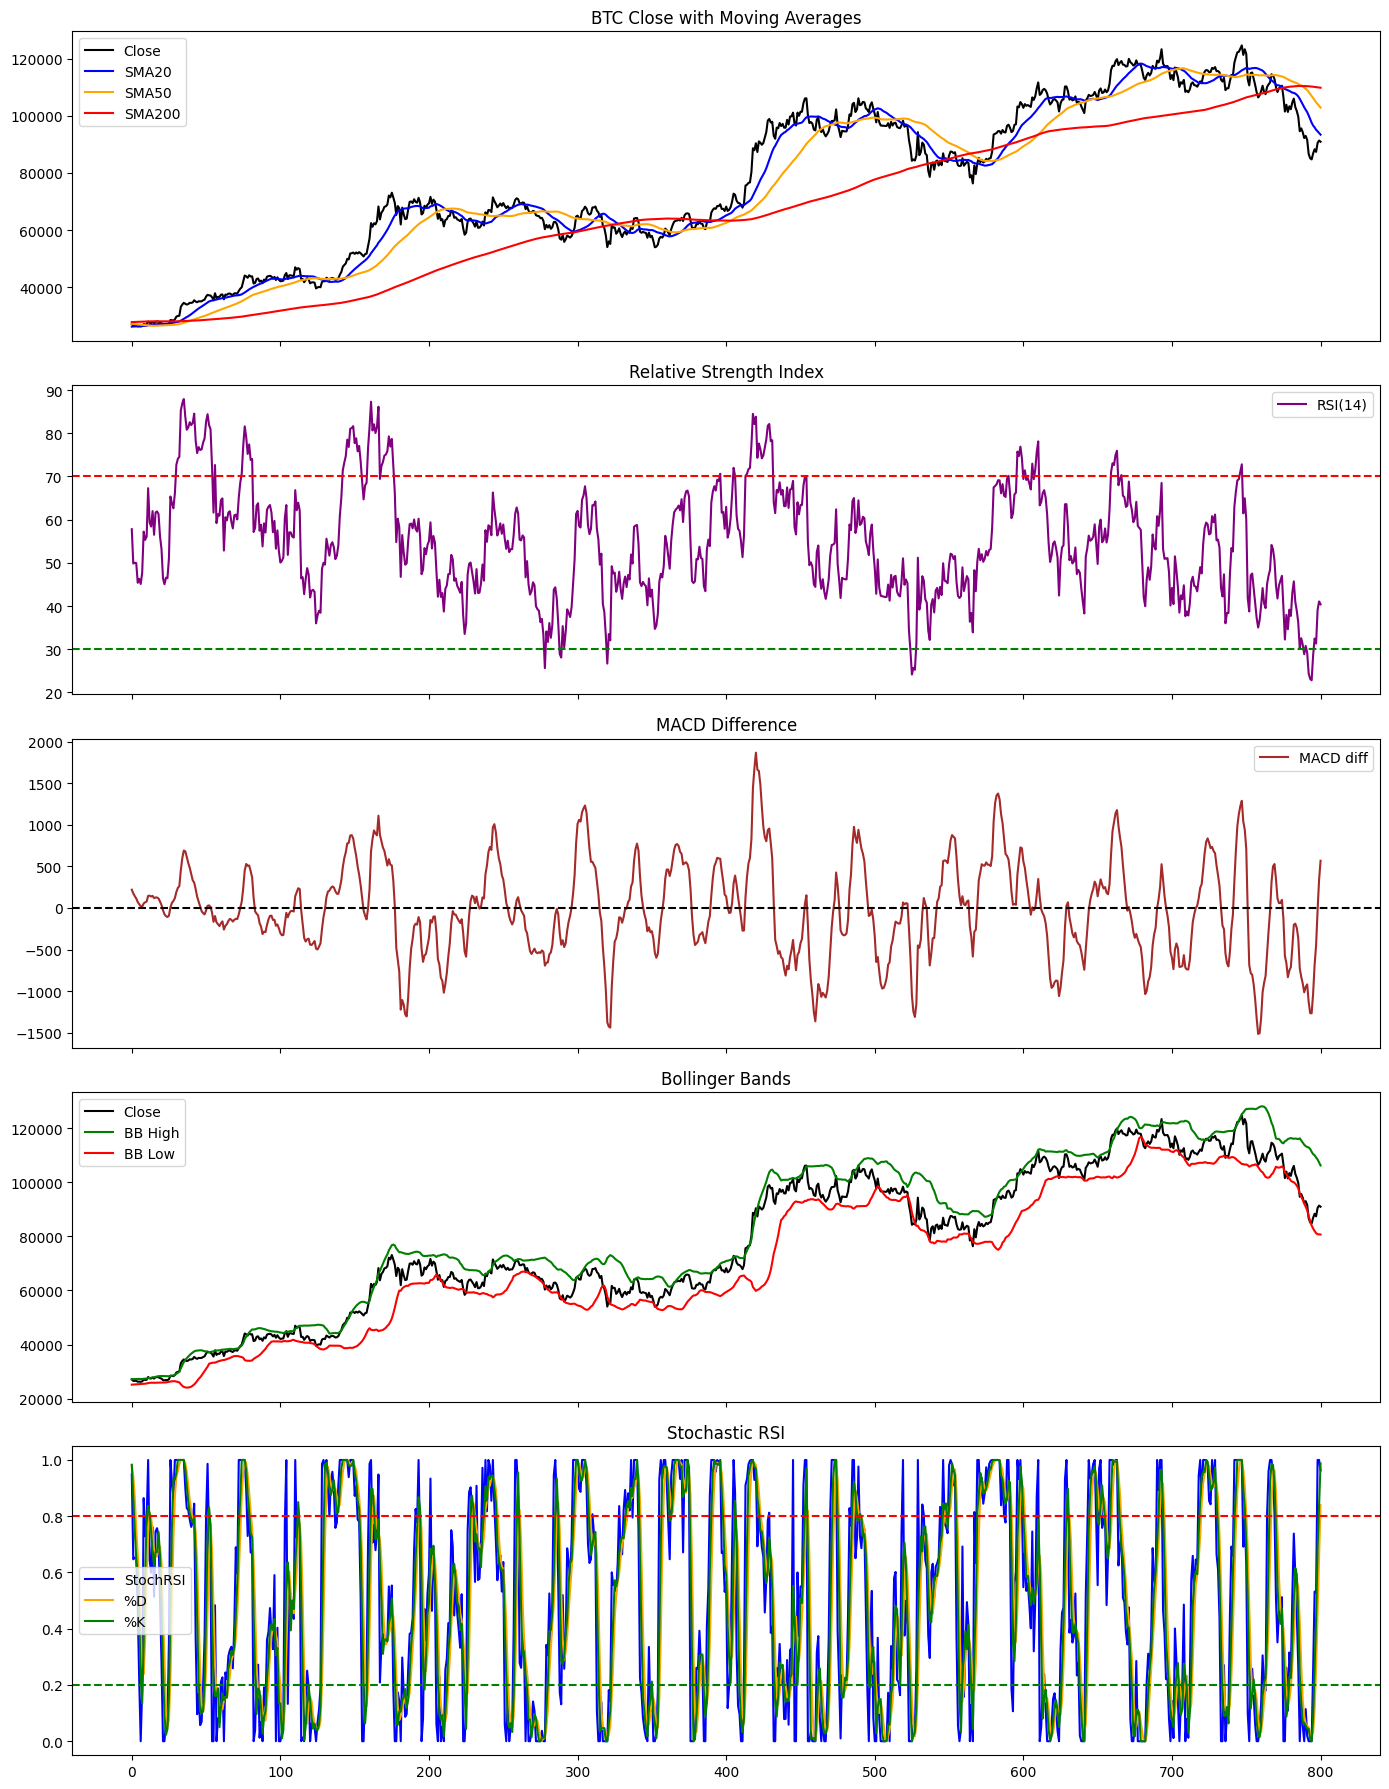

In [12]:


# After you run process_and_save and get df_features
df = process_and_save(raw_file)

# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(14, 18), sharex=True)

# 1. Closing price with SMA overlays
axes[0].plot(df["close"], label="Close", color="black")
axes[0].plot(df["sma_20"], label="SMA20", color="blue")
axes[0].plot(df["sma_50"], label="SMA50", color="orange")
axes[0].plot(df["sma_200"], label="SMA200", color="red")
axes[0].set_title("BTC Close with Moving Averages")
axes[0].legend()

# 2. RSI
axes[1].plot(df["rsi"], label="RSI(14)", color="purple")
axes[1].axhline(70, linestyle="--", color="red")
axes[1].axhline(30, linestyle="--", color="green")
axes[1].set_title("Relative Strength Index")
axes[1].legend()

# 3. MACD diff
axes[2].plot(df["macd"], label="MACD diff", color="brown")
axes[2].axhline(0, linestyle="--", color="black")
axes[2].set_title("MACD Difference")
axes[2].legend()

# 4. Bollinger Bands
axes[3].plot(df["close"], label="Close", color="black")
axes[3].plot(df["bb_high"], label="BB High", color="green")
axes[3].plot(df["bb_low"], label="BB Low", color="red")
axes[3].set_title("Bollinger Bands")
axes[3].legend()

# 5. Stochastic RSI
axes[4].plot(df["stoch_rsi"], label="StochRSI", color="blue")
axes[4].plot(df["stoch_rsi_d"], label="%D", color="orange")
axes[4].plot(df["stoch_rsi_k"], label="%K", color="green")
axes[4].axhline(0.8, linestyle="--", color="red")
axes[4].axhline(0.2, linestyle="--", color="green")
axes[4].set_title("Stochastic RSI")
axes[4].legend()

plt.tight_layout()
plt.show()

**Step 4 -Label Generation (Target Variable)**

In [14]:
df["future_return"] = df["close"].pct_change().shift(-1)

def label(row):
    if row["future_return"] > 0.02:
        return 2
    elif row["future_return"] < -0.02:
        return 0
    else:
        return 1

df["label"] = df.apply(label, axis=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   open_time           801 non-null    int64  
 1   open                801 non-null    float64
 2   high                801 non-null    float64
 3   low                 801 non-null    float64
 4   close               801 non-null    float64
 5   volume              801 non-null    float64
 6   close_time          801 non-null    int64  
 7   quote_asset_volume  801 non-null    float64
 8   num_trades          801 non-null    int64  
 9   taker_base_volume   801 non-null    float64
 10  taker_quote_volume  801 non-null    float64
 11  ignore              801 non-null    int64  
 12  return_1d           801 non-null    float64
 13  return_7d           801 non-null    float64
 14  volatility_7d       801 non-null    float64
 15  rsi                 801 non-null    float64
 16  macd    